# Matrica i agent

### Разгранување на дадена состојба ако агентот се движи во 4 насоки

In [2]:
def expand_state_4(state):
    next_states = []
    x, y = state
    neighbour_states = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
    visited=[]
    for neighbour_state in neighbour_states:
        if is_valid_square(neighbour_state):
            if neighbour_state not in visited:
                next_states.append(neighbour_state)
                visited.append(neighbour_state)
    return next_states


### Фукнции за исцртување на светот

In [3]:
def expand_state_8(state):
    next_states = []
    x, y = state
    visited=[]
    neighbour_states = [
        (x+1, y), (x-1, y), (x, y+1), (x, y-1),
        (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)]
    for neighbour_state in neighbour_states:
        if is_valid_square(neighbour_state):
            if neighbour_state not in visited:
                next_states.append(neighbour_state)
                visited.append(neighbour_state)
    return next_states


# Simulacija agent po planina

1. Надградете ја симулацијата така што агентот ќе може да се движи и во косо, односно во сите 8 насоки.
1. Надградете ја симулацијата така што целта нема да биде единствена, туку ќе биде сочинета од повеќе различни полиња.
    1. Во еден случај агентот треба да стигне до само едно поле од целта.
    1. Во друг случај агентот треба да стигне до сите полиња од целта, во произволен редослед.
    1. Во трет случај агентот треба да стигне до сите полиња од целта, во редослед чија сума на должините на делниците би била најмала.
1. Испитајте ја разликата помеѓу евклидовото растојание и менхетен за функцијата за евристика.

In [14]:
import math
from collections import deque
import heapq
from plotly import graph_objects as go
import ipywidgets as widgets

In [15]:
ROWS, COLUMNS = 20, 30
WALLS = [
    {'x': (12.5, 23.5), 'y': (7.5, 9.5)},
    {'x': (8.5, 10.5), 'y': (2.5, 13.5)},
    {'x': (16.5, 19.5), 'y': (12.5, 16.5)},
]

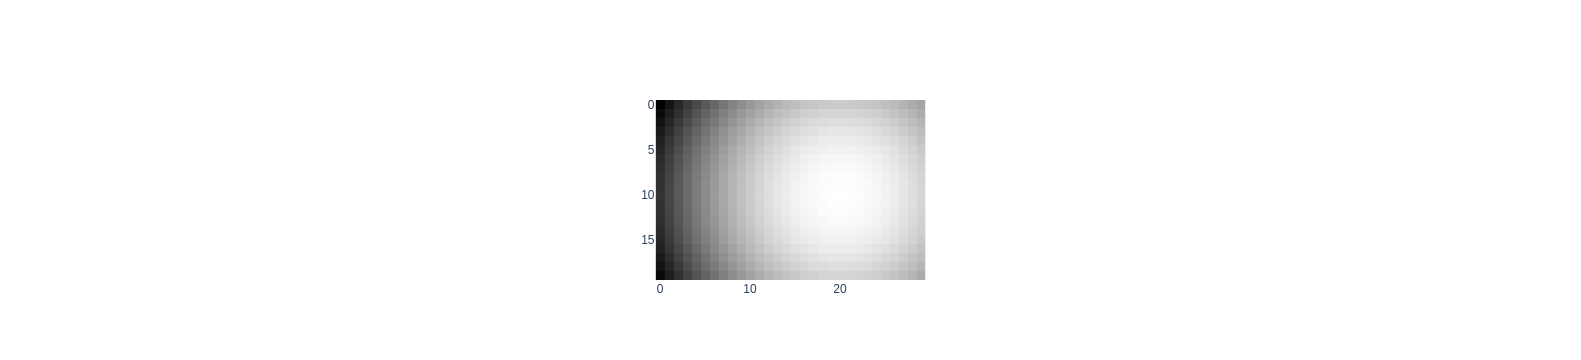

In [16]:
def create_mountain():
    def f(x, y):
        return 1 - (x - 2 * COLUMNS // 3) ** 2 - (y - ROWS // 2) ** 2

    mountain = [[f(x, y) for x in range(COLUMNS)] for y in range(ROWS)]
    min_value = min(min(mountain))
    for y in range(ROWS):
        for x in range(COLUMNS):
            mountain[y][x] = [mountain[y][x] - min_value] * 3

    min_value = min(min(min(mountain)))
    max_value = max(max(max(mountain)))
    mountain_image = go.Image(z=mountain, zmin=[min_value]*4, zmax=[max_value]*4)
    return mountain, mountain_image


MOUNTAIN, mountain_image = create_mountain()
go.Figure(mountain_image)

In [17]:
def get_weight(source_state, destination_state):
    """ Функцијата враќа колку е тешко да се движиме по планината, 
        односно тежини кај тежинскиот граф, 
        потребни за пребарувањата со униформна цена и А*
    """
    source_x, source_y = source_state
    destination_x, destination_y = destination_state
    weight = MOUNTAIN[destination_y][destination_x][0] - MOUNTAIN[source_y][source_x][0]
    return 1 + max(weight, 0)


get_weight((3, 4), (3, 5))

12

In [18]:
def eucledian_distance(state_1, state_2):
    return math.sqrt((state_1[0] - state_2[0])**2 + (state_1[1] - state_2[1])**2)


eucledian_distance((1, 2), (3, 4))

2.8284271247461903

In [20]:
def is_valid_square(square):
    x, y = square
    if not (0 <= x < COLUMNS) or not (0 <= y < ROWS):
        return False
    for wall in WALLS:
        if wall['x'][0] < x < wall['x'][1] and wall['y'][0] < y < wall['y'][1]:
            return False
    return True


is_valid_square((-1, 0))

False

In [21]:
class Simulation:
    def __init__(self, generator, start, goal):
        self.generator = generator
        self.start, self.goal = start, goal
        self.play = self.create_play()
        self.button = self.create_button()
        self.fig = self.create_fig()

    def simulate(self):
        return widgets.VBox([widgets.HBox([self.play, self.button]), self.fig])

    def update_fig(self, x):
        if self.button.disabled is True:
            return
        else:
            frontier, current_path, vertex_to_expand = next(self.generator)
            if vertex_to_expand == self.goal:
                self.button.disabled = True
                self.play.disabled = True
                self.play.value = self.play.max
        path_x = [segment[0] for segment in current_path]
        path_y = [segment[1] for segment in current_path]
        frontier_x = [segment[0] for segment in frontier]
        frontier_y = [segment[1] for segment in frontier]
        with self.fig.batch_update():
            self.fig.data[1].x = path_x
            self.fig.data[1].y = path_y
            self.fig.data[2].x = frontier_x
            self.fig.data[2].y = frontier_y
            self.fig.data[3].x = [vertex_to_expand[0]]
            self.fig.data[3].y = [vertex_to_expand[1]]

    def create_button(self):
        button = widgets.Button(description='Чекор')
        button.on_click(self.update_fig)
        return button

    def create_play(self):
        play = widgets.Play(value=0, max=3000, interval=10, show_repeat=False)
        play.observe(self.update_fig, 'value')
        return play

    def create_fig(self):
        fig = go.FigureWidget()
        for wall in WALLS:
            fig.add_shape(
                type='rect', fillcolor='RoyalBlue', 
                x0=wall['x'][0], x1=wall['x'][1], 
                y0=wall['y'][0], y1=wall['y'][1])
        fig.add_trace(mountain_image)
        fig.add_scatter(mode='lines', name='Патека')
        fig.add_scatter(mode='markers', name='Фронт')
        fig.add_scatter(marker_symbol='x', marker_size=12, name='Нареден')
        fig.add_scatter(
            x=[self.start[0]], y=[self.start[1]], marker_symbol='x',
            marker_size=12, name='Почеток')
        x = [self.goal[0]]
        y = [self.goal[1]]
        fig.add_scatter(
            x=x, y=y, marker_symbol='x', marker_size=12, name='Цел',
            mode='markers')
        fig.update_xaxes(range=[-0.5, COLUMNS - 0.5], dtick=1)
        fig.update_yaxes(range=[-0.5, ROWS - 0.5], dtick=1)
        fig.update_layout(width=36*COLUMNS, height=36*ROWS)
        return fig

In [19]:
def a_star_search(starting_vertex, goal_vertex, expand_state, heuristic, alpha):
    expanded = set()
    queue = [((0, 0), [starting_vertex])]
    heapq.heapify(queue)
    while queue:
        weight_tupple, vertex_list = heapq.heappop(queue)
        current_a_star_weight, current_path_weight = weight_tupple
        vertex_to_expand = vertex_list[-1]
        if vertex_to_expand in expanded:
            continue

        frontier = list(set([q[-1][-1] for q in queue]))
        yield frontier, vertex_list, vertex_to_expand

        for neighbour in expand_state(vertex_to_expand):
            if neighbour not in expanded:
                new_weight = get_weight(vertex_to_expand, neighbour)
                heuristic_score = heuristic(neighbour, goal_vertex)
                path_weight = current_path_weight + new_weight
                a_star_weight = path_weight + alpha * heuristic_score
                heapq.heappush(queue, ((a_star_weight, path_weight), vertex_list + [neighbour]))
        expanded.add(vertex_to_expand)
    yield [], [], goal_vertex

In [22]:
def expand_state_8(state):
    next_states = []
    x, y = state
    visited=[]
    neighbour_states = [
        (x+1, y), (x-1, y), (x, y+1), (x, y-1),
        (x-1, y-1), (x-1, y+1), (x+1, y-1), (x+1, y+1)]
    for neighbour_state in neighbour_states:
        if is_valid_square(neighbour_state):
            if neighbour_state not in visited:
                next_states.append(neighbour_state)
                visited.append(neighbour_state)
    return next_states
#barenje 1

In [25]:
start = (4, 4)
goal = [(29, 9),(20,7)]

# algorithm = breadth_first_search(start, goal, expand_state=expand_state_4)
# algorithm = depth_first_search(start, goal, expand_state=expand_state_8)
# algorithm = uniform_cost_search(start, goal, expand_state=expand_state_8)
# algorithm = gready_search(start, goal, expand_state=expand_state_8, heuristic=eucledian_distance)
algorithm = a_star_search(start, goal, expand_state=expand_state_8, heuristic=eucledian_distance, alpha=10)
algorithm

<generator object a_star_search at 0x7f96ec25b8b0>

# Iks-tochka

In [117]:
from copy import deepcopy

In [118]:
start = [
    ['.', '.', '.'],
    ['.', '.', '.'],
    ['.', '.', '.']
]

In [119]:
players = {
    'player1': ['human', 'x'], # e MAX
    'player2': ['AI', 'o'] # e MIN
}

In [120]:
def check_score(state):
    for row in state:
        if '.' in row:
            return 'keep playing'
    for row in range(3):
        if state[row][0]==state[row][1]==state[row][2]:
            return state[row][0] #kje go vrati simbolot ustvari
    for col in range(3):
        if state[0][col]==state[1][col]==state[2][col]:
            return state[0][col]
    if state[0][0]==state[1][1]==state[2][2]:
        return state[0][0]
    if state[0][2]==state[1][1]==state[2][0]:
        return state[0][2]
    
    return 'draw'

In [61]:
def expand_state(state, player):
    symbol='x' if player=='MAX' else 'o'
    states=[]
    for i in range(3):
        for j in range(3):
            if state[i][j]=='.':
                pom=deepcopy(state) #vnimavaj tuka state se staveni kako listi, ako bea tuple od tuple kje mora da se pretvora prvo vo lista 
                pom[i][j]=symbol
                states.append((pom,(i,j)))
    return states              

In [62]:
def turn(player):
    if player=='MAX':
        return 'MIN'
    else:
        return 'MAX'

In [63]:
plus_inf = float('inf')
minus_inf = float('-inf')

In [64]:
scores = {'x': 1, 'o': -1, 'draw': 0}

In [115]:
def minimax_alpha_beta(state, player, alpha=minus_inf, beta=plus_inf):
    if check_score(state)!='keep playing':
        return scores[check_score(state)],None   
    best = plus_inf if player == 'MIN' else minus_inf
    symbol='x' if player=='MAX' else 'o'
    best_move = None
    for next_state in expand_state(state,player):
        result,result_move = minimax_alpha_beta(next_state,turn(player), alpha, beta)
        if player == 'MIN':
            if result <= alpha:
                return result,best_move
            if result < beta:
                beta = result
            if result < best:
                best = result
                best_move=result_move
        elif player == 'MAX':
            if result >= beta:
                return result,best_move
            if result > alpha:
                alpha = result
            if result > best:
                best = result
                best_move=result_move
    return best,best_move

In [116]:
second_state = [
    ['o', '.', 'x'],
    ['x', 'o', 'o'],
    ['o', '.', '.']
]
best_outcome = minimax_alpha_beta(second_state, 'MAX')
print(f'Krajnata sostojba ke e')
for row in best_outcome[1]:
    print(row)
print(f'i score ke bide', {best_outcome[0]})

TypeError: check_score() missing 1 required positional argument: 'player'

In [67]:
state = [
    ['x', '.', '.'],
    ['o', '.', 'x'],
    ['.', 'o', 'x']
]
minimax_alpha_beta(state,'MAX')

IndexError: tuple index out of range

1.1. **(5 поени)** Без користење на калкулатор, дискутирајте на кој начин ќе процените колку состојби треба да се разгранат за да се истражи целото дрво на играта.

* за да се истражи цело дрво нема да користиме алба,бета поткастрување што ќе дозволи алгоритмот минимакс да пристапи до систе состојби на дрвото
* ако сакаме да ги броиме состојбите ќе поставиме глобален бројач во функцијата минимакс која ќе брои колку пати е повикана, со што ќе знаеме колку состојби се истражени

1.2. **(5 поени) (код)** Пресметајте колку точно состојби се разгрануваат за да се истражи целото дрво на играта?

In [41]:
plus_inf = float('inf')
minus_inf = float('-inf')
from copy import deepcopy
start = (
    ('·', '·', '·'),
    ('·', '·', '·'),
    ('·', '·', '·')
)
players = {
    'player1': ['human', 'x'], # e MAX
    'player2': ['AI', 'o'] # e MIN
}

In [42]:
def check_score(state):
    for row in range(3):
        if state[row][0]==state[row][1]==state[row][2]:
            return state[row][0] #kje go vrati simbolot ustvari
    for col in range(3):
        if state[0][col]==state[1][col]==state[2][col]:
            return state[0][col]
    if state[0][0]==state[1][1]==state[2][2]:
        return state[0][0]
    if state[0][2]==state[1][1]==state[2][0]:
        return state[0][2]
    for row in state:
        if '.' in row:
            return 'keep playing'
    return 'draw'

In [43]:
import copy

def expand_state(state, player):
    symbol = 'x' if player == 'MAX' else 'o'
    states = []
    for i, row in enumerate(state):
        for j, col in enumerate(row):
            if state[i][j] == '·':
                pom_state = copy.deepcopy(state)
                pom_state[i][j] = symbol
                states.append((pom_state, (i, j)))
    return states  

In [44]:
def turn(player):
    if player=='MAX':
        return 'MIN'
    else:
        return 'MAX'

In [45]:
def minimax(state, player):
    global c
    c+=1
    if check_score(state)!='keep playing':
        return scores[check_score(state)],None
    best_move=None
    best = plus_inf if player == 'MIN' else minus_inf
    symbol='x' if player=='MAX' else 'o'
    for next_state,next_move in expand_state(state,player):
        result,result_move = minimax(next_state,turn(player))
        if player == 'MIN' and result < best:
            best = result
            best_move=result_move
        elif player == 'MAX' and result > best:
            best = result
            best_move=result_move
    return best,best_move

In [46]:
second_state = [
    ['o', '·', 'x'],
    ['x', '.', 'o'],
    ['o', '·', 'o']
]
c=0
best_outcome = minimax(second_state, 'MAX')
best_outcome
c

5

In [62]:
expand_state(second_state,'MIN')

[([['o', 'o', 'x'], ['x', '.', 'o'], ['o', '·', 'o']], (0, 1)),
 ([['o', '·', 'x'], ['x', '.', 'o'], ['o', 'o', 'o']], (2, 1))]

1.3. **(5 поени)** Што е алфа-бета поткастрување? Зошто користиме алфа-бета поткастрување во оваа игра?

* тоа е всушност олеснување на минимакс алгоритмот што овозможува овој алгоритам да работи многу побрзо
* како работи? така што однапред предвидува, на пример ако го разгрануваме првиот јазол од долу и на ред е МИН играчот, тој од 2 јазли ќе го одбере помалиот, потоа од вториот пар јазли барем првиот во себе носи вредност помала од онаа од првите два јазли, не го ни разгледува вториот, затоа што следниот чекор е на МАКС и тој секкао би ја зел поголемата вредност он онаа која МИН тука би ја земал.
* користиме затоа што алгоритмот ќе разгледува многу помал број чекори и играта че се одвива побрзо

1.4. **(10 поени) (код)** Покажете дека користењето на постапката за алфа-бета поткастрување се исплати во оваа игра. На кој начин подобро ќе се покаже: (1) преку времето потребно за извршување на алгоритмите или (2) преку броење на разгранетите јазли?

* бидејќи дрвото е мало, возможно е да се направи броење на јазли кои ги изминува алгоритмот, при што со поткаструвањето ќе има помал број поминати јазли, но оваа разлика се забележува и преку времето, а времето би било и поефективен и по брз покажувач при поголеми дрва со повеќе јазли бидејќи разликата во времето при решавање со и без поткастрување ќе биде значителна

In [47]:
def minimax_alpha_beta(state, player, alpha=minus_inf, beta=plus_inf):
    global c
    c+=1
    if check_score(state)!='keep playing':
        return scores[check_score(state)],None   
    best = plus_inf if player == 'MIN' else minus_inf
    symbol='x' if player=='MAX' else 'o'
    best_move=None
    for next_state,next_move in expand_state(state,player):
        result,result_move = minimax_alpha_beta(next_state,turn(player), alpha, beta)
        if player == 'MIN':
            if result <= alpha:
                return result
            if result < beta:
                beta = result
            if result < best:
                best = result
                best_move=result_move
        elif player == 'MAX':
            if result >= beta:
                return result
            if result > alpha:
                alpha = result
            if result > best:
                best = result
                best_move=result_move
    return best, best_move

In [48]:
second_state = [
    ['o', '·', 'x'],
    ['x', '.', 'o'],
    ['o', '·', 'o']
]
c=0
best_outcome = minimax(second_state, 'MAX')
best_outcome
c

5

1.5. **(10 поени)** Предложете функција за евристика за оваа игра.

* ако дрвото беше преголемо корисно е да се користи евристика за да не мора да се троши време на размислување на секој нареден чекор
* во предност ќе биде оној кој има 2последователни симболи еден до друг, или пак 2 со едно празно место измеѓу, оној кој има повеќе такви е во предност
* ќе се користи да се повика кога ќе дојде на ред играчот и ќе се keep track кој е во предност со тоа кој има поголем број на вакви парови

1.6. **(10 поени) (код)** Имплементирајте ја предложената функција од прашањето 5.

In [ ]:
global count=0

In [156]:
def count(state,player):
    global count
    symbol='x' if player=='MAX' else 'o'
    if state[0][0]==state[1][1]:
        count+=1
    if state[0][0]==state[2][2]:
        count+=1
    if state[2][2]==state[1][1]:
        count+=1
    if state[0][2]==state[1][1]:
        count+=1
    if state[0][2]==state[2][0]:
        count+=1
    if state[2][0]==state[1][1]: #tuka gi proveruva diagonalite po parovi, i glavna i sporedna
        count+=1
    for row,i in enumerate(state):
        for col,j in enumerate(i):
            if state[row][col]==state[row+1][col]:
                count+=1
            if state[row][col]==state[row+2][col]:    #tuka gi proveruva po koloni i redovi dali ima eden do drug ili preku drug isti
                count+=1
            if state[row][col]==state[row][col+1]:
                count+=1
            if state[row][col]==state[row][col+2]:
                count+=1
    return count

In [ ]:
def winner(state):
    global count
    count=0
    count_MAX=count(state,'MAX')
    count=0
    count_MIN=count(state,'MIN')
    if count_MAX>count_MIN:
        print('The winner is x')
    else: 
        print('The winner is o')

# Hexapawn

In [128]:
from copy import deepcopy
plus_inf = float('inf')
minus_inf = float('-inf')
players = {
    'player1': ['human', 'x'], # e MAX
    'player2': ['AI', 'o'] # e MIN
}

In [129]:
start = (
    ('x', 'x', 'x'),
    ('.', '.', '.'),
    ('o', 'o', 'o')
)

In [130]:
def turn(player):
    if player=='MAX':
        return 'MIN'
    else:
        return 'MAX'

In [133]:
def check_score(state,player):
    symbol='x' if player=='MAX' else 'o'
    other='o' if player=='MIN' else 'x'
    for row in enumerate(state):
        iks=row.count(symbol)
        os=row.count(other)
    if iks==os:
        return 'keep playing'
    elif iks>os:
        return symbol
    else: return other

In [134]:
def expand_state(state, player):
    symbol='x' if player=='MAX' else 'o'
    states=[]
    pom=[]
    for row,i in enumerate(state):
        for col,j in enumerate(i):
            if row+1<3:
                if state[row+1][col]=='.':
                    for m in state:
                        pom.append(list(m))
                    pom[row][col]=symbol
                    states.append((pom,(row,col)))
            if col+1<3:
                if state[row][col+1]=='.':
                    for m in state:
                        pom.append(list(m))
                    pom[row][col]=symbol
                    states.append((pom,(row,col)))
            if row+1<3:        
                if state[row+1][col]!='.' and state[row+1][col]!=symbol:
                    for m in state:
                        pom.append(list(m))
                    pom[row][col]=symbol
                    states.append((pom,(row,col)))
            if col+1<3:                
                if state[row][col+1]=='.' and state[row][col+1]!=symbol:
                    for m in state:
                        pom.append(list(m))
                    pom[row][col]=symbol
                    states.append((pom,(row,col)))
    return states  

In [140]:
def minimax(state,player):
    if check_score(state,player)!='keep playing':
        return check_score(state,player)
    best = plus_inf if player == 'MIN' else minus_inf
    for next_state in expand_state(state,player):
        result = minimax(next_state, turn(player))
        if player == 'MIN' and result < best:
            best = result
        elif player == 'MAX' and result > best:
            best = result
    return best

In [141]:
statee= (
    ('o', 'x', 'x'),
    ('·', 'x', '·'),
    ('o', '.', 'o')
)
count=0
best_outcome=minimax(statee, 'MAX')
best_outcome
count

IndexError: tuple index out of range

# Amazon

In [19]:
from time import sleep
from plotly import graph_objects as go
import ipywidgets as ipw
from IPython import display
from copy import deepcopy

In [108]:
N = 5
state = (
('·', '·', '·', '·', 'S'),
('·', 'x', '·', '·', 'x'),
('·', 'P', 'x', 'x', 'x'),
('·', '·', 'x', '·', 'x'),
('·', '·', '·', '·', '·'))

In [79]:
def valid(state,position):
    x,y=position
    if 0<=x<N and 0<=y<N:
        if state[x][y]=='.':
            return True
        else: return False
    else: return False

In [80]:
valid(state,(2,2))

False

In [87]:
def winner(state):
    moves_S=[]
    moves_P=[]
    for i,row in enumerate(state):
        for j,col in enumerate(row):
            if col=='S':
                position_St=(i,j)
            if col=='P':
                position_Pt=(i,j)
    directions = ((0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1))
    for x,y in directions:
        position_S=list(position_St)
        position_P=list(position_Pt)
        position_S[0]+=x
        position_S[1]+=y
        while valid(state,position_S):
            moves_S.append(tuple(position_S))
            position_S[0]+=x
            position_S[1]+=y
        position_P[0]+=x
        position_P[1]+=y
        while valid(state,position_P):
            moves_P.append(tuple(position_P))
            position_P[0]+=x
            position_P[1]+=y
    print(f'P ima {len(moves_P)} mozni potezi')
    print(moves_P)
    print()
    print(f'S ima {len(moves_S)} mozni potezi')
    print(moves_S)
    if len(moves_S)>len(moves_P):
        print('Pobednik e S')
    if len(moves_S)==len(moves_P):
        print('Draw')
    if len(moves_S)<len(moves_P):
        print('Pobednik e P')

In [88]:
winner(state)

P ima 0 mozni potezi
[]

S ima 0 mozni potezi
[]
Draw


Евристика: ако до полето побрзо се стига со црна кралица, нејзино е, ако не, на белата

In [45]:
test_state = (
('·', '·', '·', '·', 'S'),
('·', '·', '·', '·', '·'),
('·', 'P', '·', '·', '·'),
('·', '·', '·', '·', '·'),
('·', '·', '·', '·', '·'))

state = (
('·', '·', '·', '·', 'S'),
('·', 'x', '·', '·', 'x'),
('·', 'P', 'x', 'x', 'x'),
('·', '·', 'x', '·', 'x'),
('·', '·', '·', '·', '·'))

goal_state = (
('·', '·', 'P', '·', 'S'),
('·', 'x', '·', '·', 'x'),
('·', '·', 'x', 'x', 'x'),
('·', '·', 'x', '·', 'x'),
('·', '·', '·', '·', '·'))

In [46]:
def find_queen(state,color):
    symbol='S' if color=='white' else 'P'
    for i, row in enumerate(state):
        for j, col in enumerate(row):
            if col==symbol:
                return (i,j)

In [121]:
def move(state,color,position):
    initialp=find_queen(state,color)
    x,y=initialp
    new_x,new_y=position
    symbol='S' if color=='white' else 'P'
    states=[]
    for row in state:
        states.append(list(row))
    states[x][y]='.'
    states[new_x][new_y]=symbol
    state_tuple=[]
    for row in states:
        state_tuple.append(tuple(row))
    return state_tuple

In [113]:
def arrow(state,position):
    x,y=position
    states=[]
    for row in state:
        states.append(list(row))
    states[x][y]='x'
    for row in states:
        state_tuple.append(tuple(row))
    return state_tuple

In [114]:
def expand_state(state,color,N,arrow=False):
    states=[]
    directions = ((0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1))
    for x,y in directions:
        qx,qy=find_queen(state,color)
        while valid(state,(x+qx,y+qy)):
            states.append(((x+qx,y+qy),move(state,color,(x+qx,y+qy))))
            qx+=x
            qy+=y
    if arrow==False:
        return states
    
    states_arrows=[]
    for state_index, (position,expanded_state) in enumerate(states):
        for x,y in directions:
            qx, qy = find_queen(expanded_state,color)
            while valid(state, (qx+x, qy+y)):
                states_arrows.append((states_list[state_index][1],arrow(expanded_state, (qx+x, qy+y))))
                qx+=x 
                qy+=y
    return states_arrows

In [115]:
expand_state(test_state, 'black', 5)[:3]

[]

In [116]:
def chebyshev_distance(state_1, state_2):
    return max(abs(state_1[0] - state_2[0]), abs(state_1[1] - state_2[1])) #ova e heuristic_function

In [117]:
import heapq

In [104]:
def a_star_search(state,goal_state,color,heuristic_function,alpha=1):
    expanded = set()
    queue = [((0, 0), [state])]
    heapq.heapify(queue)
    while queue:
        weight_tuple, vertex_list = heapq.heappop(queue)
        current_a_star_weight, current_path_weight = weight_tuple
        vertex_to_expand = vertex_list[-1]
        if vertex_to_expand == goal_state:
            return current_path_weight, vertex_list
        if vertex_to_expand not in expanded:
            for next_state, next_position in expand_state(vertex_to_expand,color,False): #bez streli zoshto zema mnogu vreme
                if next_state not in expanded:
                    heuristic = heuristic_function(next_state, goal_state)
                    path_weight = current_path_weight + 1
                    a_star_weight = path_weight + alpha * heuristic
                    heapq.heappush(queue, ((a_star_weight, path_weight), vertex_list + [neighbour]))
        expanded.add(vertex_to_expand)

In [122]:
def who_owns_square(state, square_position, N):
    x, y = square_position
    number_of_moves = []
    for queen_color in ['white', 'black']:
        goal_state = move(state, queen_color,square_position)
        number_of_moves.append(a_star_search(state, goal_state, queen_color, N)[0])
        
    if number_of_moves[0] > number_of_moves[1]: # ako white pravi povekje moves za da stigne do istoto mesto
        return -1
    elif number_of_moves[0] > number_of_moves[1]:
        return 1
    else:
        return 0

In [39]:
def who_is_at_advantage(state, N):
    total_score = 0
    for row_index, row in enumerate(state):
        for col_index, element in enumerate(row):
            if element == '·':
                score = who_owns_square(state, (row_index, col_index), N)
                total_score += score # ke e <0 ako black ima povekje polinja, ke e >0 ako white ima povekje polinja
    return total_score

In [40]:
who_is_at_advantage(state, 5)

NameError: name 'state' is not defined

In [41]:
# find_queen e kod napisan od stefan, vrakja vo koja redica (x) i kolona (y) se naogja kralicata so simbol S ili P
def find_queen(state, queen_symbol):
    N = len(state)
    for x in range(N):
        for y in range(N):
            if state[x][y] == queen_symbol:
                return x, y

def freedom_queen(state, symbol):
    N = len(state)
    how_many = 0 # how_many e brojot na slobodni polinja koi se naogjaat okolu kralicata so simbol 'symbol'
    x, y = find_queen(state, symbol)
    directions = [
        (0, 1), (0, -1), (1, 0), (-1, 0),
        (1, 1), (1, -1), (-1, 1), (-1, -1)
    ]
    for dx, dy in directions:
        nx, ny = x + dx, y + dy # nx i ny davaat pozicija na pole koe se naogja levo, desno, gore, dolu ili dijagonalno od kralicata
        # (na primer ako go razgleduvame elementot (0, 1) od directions, toa znaci deka go razgleduvame poleto sho se naogja desno od kralicata)
        if 0 <= nx < N and 0 <= ny < N and state[ny][nx] == '·': # ako poleto so pozicija nx i ny e validno t.e. e prazno i se naogja vo ramkite na tablata
            how_many += 1 
    return how_many/8 # maksimum 8 prazni polinja mozi da ima okolu kralicata, zatoa delime so 8 (bidejki vo slucajot trebase da dobieme
    # broj megu 0 i 1, stefan taka ni specificira)


def evaluate_state(state):
    freedom_s = freedom_queen(state, 'S')
    freedom_p = freedom_queen(state, 'P')
    return freedom_s - freedom_p # brojot ke e pozitiven ako S (koj sto e MAX igrac) ima pogolema sloboda (t.e. ima poveke prazni
    # polinja okolu nego), a negativen ako P (MIN) ima pogolema sloboda

In [43]:
#minimax so dlabochina
def minimax_alpha_beta(state, player,alpha=minus_inf, beta=plus_inf, depth=0):
    if check_score(state,player)!= 'keep_playing':
        return scores[check_score(state)],None 
    # пример како да се прекине со пребарување после длабочина 3
    if depth == 3:
        return evaluate_state(state),None
    best = plus_inf if player == 'MIN' else minus_inf
    best_move = None
    symbol='x' if player=='MAX' else 'o'
    for next_state, next_move in expand_state(state, player):
        result, result_move = minimax(next_state, turn(player),alpha,beta,depth+1)
        if player == 'MIN':
            if result <= alpha:
                return result, best_move
            if result < beta:
                beta = result
            if result < best:
                best = result
                best_move = move
        elif player == 'MAX':
            if result >= beta:
                return result, best_move
            if result > alpha:
                alpha = result
            if result > best:
                best = result
                best_move = result_move
    return best, best_move

# Connect 4

In [1]:
from time import sleep
from collections import deque
from copy import deepcopy
from plotly import graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [25]:
#kje se razgleduva tabla 6x7
plus_inf = float('inf')
minus_inf = float('-inf')

In [3]:
start = (
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','.','.'),
)

In [4]:
def turn(player):
    if player=='MAX':
        return 'MIN'
    else:
        return 'MAX'

In [5]:
scores = {'x': 1, 'o': -1, 'draw': 0}

In [6]:
def check_score(state,player):
    symbol='x' if player=='MAX' else 'o'
    other='o' if player=='MIN' else 'x'
    for row in range(6):
        for col in range(7):
            if (col+3)<7:
                if state[row][col]==state[row][col+1]==state[row][col+2]==state[row][col+3] and state[row][col]!='.': #dali 4 ima po koloni
                    return state[row][col]
    for col in range(7):
        for row in range(6):
            if (row+3)<6:
                if state[row][col]==state[row+1][col]==state[row+2][col]==state[row+3][col] and state[row][col]!='.': #dal 4 ima po redici
                    return state[row][col]
    for row in range(6):
        for col in range(6):
            if (row+3)<6 and (col+3)<6:
                if state[row][col]==state[row+1][col+1]==state[row+2][col+2]==state[row+3][col+3] and state[row][col]!='.': #glavna dijagonala
                    return state[row][col]
    for col in reversed(range(7)):
        for row in range(5):
            if (row+3)<6 and (col-3)>0:
                if state[row][col]==state[row+1][col-1]==state[row+2][col-2]==state[row+3][col-3] and state[row][col]!='.': #sporedna dijagonala
                    return state[row][col]
    return 'keep playing'

In [9]:
state = (
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','.','.'),
    ('.', '.', '.','.','.','o','.'),
    ('.', '.', 'o','.','x','x','.'),
    ('.', '.', 'o','x','o','x','.'),
    ('.', 'x', 'o','x','x','x','.'),
)
check_score(state,'MAX')

'keep playing'

In [14]:
def expand_state(state, player):
    states = []
    symbol = 'x' if player == 'MAX' else 'o'
    for col_i in range(7):
        row_i = 5
        while state[row_i][col_i] != '.' and row_i >= 0:
            row_i -= 1
        if state[0][col_i] == '.':
            state_pom = list(list(row) for row in state)
            state_pom[row_i][col_i] = symbol
            states.append((list(state_pom), (row_i, col_i)))
    return states

In [15]:
expand_state(state, 'MAX')

[([['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', 'o', '.'],
   ['.', '.', 'o', '.', 'x', 'x', '.'],
   ['.', '.', 'o', 'x', 'o', 'x', '.'],
   ['x', 'x', 'o', 'x', 'x', 'x', '.']],
  (5, 0)),
 ([['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', 'o', '.'],
   ['.', '.', 'o', '.', 'x', 'x', '.'],
   ['.', 'x', 'o', 'x', 'o', 'x', '.'],
   ['.', 'x', 'o', 'x', 'x', 'x', '.']],
  (4, 1)),
 ([['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', 'x', '.', '.', 'o', '.'],
   ['.', '.', 'o', '.', 'x', 'x', '.'],
   ['.', '.', 'o', 'x', 'o', 'x', '.'],
   ['.', 'x', 'o', 'x', 'x', 'x', '.']],
  (2, 2)),
 ([['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', '.', '.'],
   ['.', '.', '.', '.', '.', 'o', '.'],
   ['.', '.', 'o', 'x', 'x', 'x', '.'],
   ['.', '.', 'o', 'x', 'o', 'x', '.'],
   ['.', 'x', 'o', 'x', 'x', 'x', '.']],
  (

In [22]:
#pobednik kje bide onoj shto ima povekje 3ki redosledno, toest znaci mu falelo 1 za da pobedi
def evaluate_state(state,player):
    symbol='x' if player=='MAX' else 'o'
    other='o' if player=='MIN' else 'x'
    counter_x=0
    counter_o=0
    for row in range(6):
        for col in range(7):
            if (col+2)<7:
                if state[row][col]==state[row][col+1]==state[row][col+2] and state[row][col]!='.': #dali 3 ima po koloni
                    if state[row][col]==symbol:
                        counter_x+=1
                    else: counter_o+=1
    for col in range(7):
        for row in range(6):
            if (row+2)<6:
                if state[row][col]==state[row+1][col]==state[row+2][col] and state[row][col]!='.': #dali 3 ima po redici
                    if state[row][col]==symbol:
                        counter_x+=1
                    else: counter_o+=1
    for row in range(6):
        for col in range(6):
            if (row+2)<6 and (col+2)<6:
                if state[row][col]==state[row+1][col+1]==state[row+2][col+2] and state[row][col]!='.': #glavna dijagonala
                    if state[row][col]==symbol:
                        counter_x+=1
                    else: counter_o+=1
    for col in reversed(range(7)):
        for row in range(5):
            if (row+2)<5 and (col-2)>0:
                if state[row][col]==state[row+1][col-1]==state[row+2][col-2] and state[row][col]!='.': #sporedna dijagonala
                    if state[row][col]==symbol:
                        counter_x+=1
                    else: counter_o+=1
    if counter_x>counter_o:
        return 'x'
    else: return 'o'

In [28]:
#minimax so dlabochina
def minimax(state, player,alpha=-2, beta=2, depth=0):
    if check_score(state,player)!= 'keep playing':
        return check_score(state,player),None 
    # пример како да се прекине со пребарување после длабочина 3
    if depth == 3:
        return evaluate_state(state,player),None
    best = plus_inf if player == 'MIN' else minus_inf
    best_move = None
    symbol='x' if player=='MAX' else 'o'
    for next_state, next_move in expand_state(state, player):
        result, _ = minimax(next_state, turn(player),alpha,beta,depth+1)
        if player == 'MIN':
            if result <= alpha:
                return result, best_move
            if result < beta:
                beta = result
            if result < best:
                best = result
                best_move = next_move
        elif player == 'MAX':
            if result >= beta:
                return result, best_move
            if result > alpha:
                alpha = result
            if result > best:
                best = result
                best_move = next_move
    return best, best_move

In [30]:
state=(
    ('x', 'x', '.','.','.','.','.'),
    ('.', '.', '.','.','.','x','.'),
    ('.', 'o', '.','x','.','.','.'),
    ('x', '.', '.','x','.','.','x'),
    ('.', 'o', '.','x','o','o','o'),
    ('x', 'o', '.','.','.','.','.'),
)
minimax_alpha_beta(state, 'MAX',alpha=-2, beta=2, depth=0)

TypeError: '>=' not supported between instances of 'str' and 'int'